# Analysis of [Compass](https://github.com/YosefLab/Compass) results

In [110]:
# taken from https://github.com/YosefLab/Compass/blob/docs/notebooks/compass_analysis.py
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ranksums
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hcluster
from scipy.spatial.distance import squareform

def cohens_d(x, y):
    pooled_std = np.sqrt(((len(x)-1) * np.var(x, ddof=1) 
                          + (len(y)-1) * np.var(y, ddof=1)) / 
                             (len(x) + len(y) - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std
    

def wilcoxon_test(consistencies_matrix, group_A_cells, group_B_cells):
    """
        Performs an unpaired wilcoxon test (or mann-whitney U test) for each reaction between group_A and group_B
    """
    #per reaction/meta-reaction, conduct wilcoxon test between group_A and group_B
    group_A = consistencies_matrix.loc[:,group_A_cells]
    group_B = consistencies_matrix.loc[:,group_B_cells]
    results = pd.DataFrame(index = consistencies_matrix.index, columns = ['wilcox_stat', 'wilcox_pval', 'cohens_d'], dtype='float64')
    for rxn in consistencies_matrix.index:
        A, B = group_A.loc[rxn].to_numpy().ravel(), group_B.loc[rxn].to_numpy().ravel()
        stat, pval = mannwhitneyu(A, B, alternative='two-sided')
        c_d = cohens_d(A, B)
        results.loc[rxn, ['wilcox_stat', 'wilcox_pval', 'cohens_d']] = stat, pval, c_d
    results['adjusted_pval'] = np.array(multipletests(results['wilcox_pval'], method='fdr_bh', alpha = 0.1)[1], dtype='float64')
    return results

def get_reaction_consistencies(compass_reaction_penalties, min_range=1e-3):
    """
        Converts the raw penalties outputs of compass into scores per reactions where higher numbers indicate more activity
    """
    df = -np.log(compass_reaction_penalties + 1)
    df = df[df.max(axis=1) - df.min(axis=1) >= min_range]
    df = df - df.min().min()
    return df

def get_metareactions(reactions, height=0.02):
    """
        Returns an array of metareaction labels for each reaction
        Index k in the returned array has the metareaction label for reaction k.
    """
    #pairwise_reaction_correlations = reactions.T.corr(method='spearman') #Pandas method here is orders of magnitude slower
    pairwise_reaction_correlations = np.corrcoef(reactions.rank(axis=1))
    #Unfortunately due to floating point issues, these matrices are not always perfectly symmetric and the diagonal may be slightly off from 1
    pairwise_reaction_correlations[np.arange(reactions.shape[0]), np.arange(reactions.shape[0])] = 1.0
    pairwise_reaction_correlations = (pairwise_reaction_correlations + pairwise_reaction_correlations.T)/2
    assert(np.all(pairwise_reaction_correlations == pairwise_reaction_correlations.T))

    Z = hcluster.complete(squareform(1 - pairwise_reaction_correlations))
    return hcluster.fcluster(Z, height, criterion='distance')

labeled_reactions = {}

relevant_subsystems = [
    'Fatty acid oxidation', 
    'Arachidonic acid metabolism',
    'Glycerophospholipid metabolism',
    'Sphingolipid metabolism',
    'Glycolysis/gluconeogenesis', 
    'Oxidative phosphorylation',
    'Pyrimidine synthesis',
    'Pyrimidine catabolism',
    'beta-Alanine metabolism'
]

# custom functions
def load_reactions(disease_reactions_file, control_reactions_file, disease_label, control_label):
    ddf = pd.read_csv(
        disease_reactions_file,
        sep = '\t',
        index_col = 0,
        compression = 'gzip'
    )
    cdf = pd.read_csv(
        control_reactions_file,
        sep = '\t',
        index_col = 0,
        compression = 'gzip'
    )
    for df, label in zip([ddf, cdf], [disease_label, control_label]):
        df.columns = ['_'.join([label, column]) for column in df.columns]
        
    df = ddf.merge(
        cdf,
        how = 'left',
        left_index = True,
        right_index = True
    )
    return df

In [36]:
# only need to be run if you didn't download it yet
#!wget https://github.com/YosefLab/Compass/raw/docs/notebooks/extdata/RECON2/reaction_metadata.csv -O ../compass/recon2_reaction_metadata.csv

In [37]:
reaction_metadata = pd.read_csv(
    "../compass/recon2_reaction_metadata.csv", 
    index_col = 0
)
reaction_metadata

,reaction_name,formula,associated_genes,subsystem,EC_number,confidence
reaction_no_direction,,,,,,
10FTHF5GLUtl,"5-glutamyl-10FTHF transport, lysosomal",1.00 * 10-formyltetrahydrofolate-[Glu](5) [c] ...,NaN,"Transport, lysosomal",NaN,2.0
10FTHF5GLUtm,"5-glutamyl-10FTHF transport, mitochondrial",1.00 * 10-formyltetrahydrofolate-[Glu](5) [m] ...,NaN,"Transport, mitochondrial",NaN,2.0
10FTHF6GLUtl,"6-glutamyl-10FTHF transport, lysosomal",1.00 * 10-formyltetrahydrofolate-[Glu](6) [c] ...,NaN,"Transport, lysosomal",NaN,2.0
10FTHF6GLUtm,"6-glutamyl-10FTHF transport, mitochondrial",1.00 * 10-formyltetrahydrofolate-[Glu](6) [m] ...,NaN,"Transport, mitochondrial",NaN,2.0
10FTHF7GLUtl,"7-glutamyl-10FTHF transport, lysosomal",1.00 * 10-formyltetrahydrofolate-[Glu](7) [c] ...,NaN,"Transport, lysosomal",NaN,2.0
...,...,...,...,...,...,...
MAL_Lte,Transport of L-malate,1.00 * (S)-malate(2-) [e] --> 1.00 * (S)-malat...,NaN,"Transport, extracellular",NaN,NaN
OROTGLUt,OROTGLUt,1.00 * L-glutamate(1-) [c] + 1.00 * Orotate [e...,SLC22A7,"Transport, extracellular",NaN,NaN
PNTOte,Transport of (R)-Pantothenate,1.00 * (R)-Pantothenate [e] --> 1.00 * (R)-Pan...,NaN,"Transport, extracellular",NaN,NaN


In [38]:
reaction_metadata[
    reaction_metadata.associated_genes.apply(lambda x: x.startswith('SLC7A5') if type(x) == str else False)
]

,reaction_name,formula,associated_genes,subsystem,EC_number,confidence
reaction_no_direction,,,,,,
r1544,Amino Acid-Polyamine-Organocation (APC) TCDB:2...,1.00 * L-glutamine [c] + 1.00 * Glycine [e] --...,SLC7A5,"Transport, extracellular",NaN,0.0
r1546,Amino Acid-Polyamine-Organocation (APC) TCDB:2...,1.00 * Glycine [e] + 1.00 * L-methionine [c] -...,SLC7A5,"Transport, extracellular",NaN,0.0
r1547,Amino Acid-Polyamine-Organocation (APC) TCDB:2...,1.00 * Glycine [e] + 1.00 * L-tryptophan [c] -...,SLC7A5,"Transport, extracellular",NaN,0.0
r1548,Amino Acid-Polyamine-Organocation (APC) TCDB:2...,1.00 * Glycine [e] + 1.00 * L-phenylalanine [c...,SLC7A5,"Transport, extracellular",NaN,0.0
r1549,Amino Acid-Polyamine-Organocation (APC) TCDB:2...,1.00 * Glycine [e] + 1.00 * L-tyrosine [c] -->...,SLC7A5,"Transport, extracellular",NaN,0.0
...,...,...,...,...,...,...
r1658,Amino Acid-Polyamine-Organocation (APC) TCDB:2...,1.00 * L-valine [e] + 1.00 * L-homoserine [c] ...,SLC7A5,"Transport, extracellular",NaN,0.0
r1659,Amino Acid-Polyamine-Organocation (APC) TCDB:2...,1.00 * L-valine [e] + 1.00 * L-isoleucine [c] ...,SLC7A5,"Transport, extracellular",NaN,0.0
r1660,Amino Acid-Polyamine-Organocation (APC) TCDB:2...,1.00 * L-threonine [e] + 1.00 * L-homoserine [...,SLC7A5,"Transport, extracellular",NaN,0.0


In [39]:
np.sort(reaction_metadata.subsystem.unique())

array(['Alanine and aspartate metabolism', 'Alkaloid synthesis',
       'Aminosugar metabolism',
       'Androgen and estrogen synthesis and metabolism',
       'Arachidonic acid metabolism', 'Arginine and Proline Metabolism',
       'Bile acid synthesis', 'Biotin metabolism',
       'Blood group synthesis', 'Butanoate metabolism',
       'C5-branched dibasic acid metabolism', 'Cholesterol metabolism',
       'Chondroitin sulfate degradation', 'Chondroitin synthesis',
       'Citric acid cycle', 'CoA catabolism', 'CoA synthesis',
       'Cysteine Metabolism', 'Cytochrome metabolism',
       'D-alanine metabolism', 'Dietary fiber binding',
       'Eicosanoid metabolism', 'Exchange/demand reaction',
       'Fatty acid oxidation', 'Fatty acid synthesis',
       'Folate metabolism', 'Fructose and mannose metabolism',
       'Galactose metabolism', 'Glutamate metabolism',
       'Glutathione metabolism', 'Glycerophospholipid metabolism',
       'Glycine, serine, alanine and threonine metabo

In [42]:
reaction_metadata[
    reaction_metadata.subsystem.isin(relevant_subsystems)
]

,reaction_name,formula,associated_genes,subsystem,EC_number,confidence
reaction_no_direction,,,,,,
13DAMPPOX,"1,3-Diaminopropane:oxygen oxidoreductase (deam...",1.00 * trimethylenediaminium [c] + 1.00 * Wate...,AOC1; AOC2; AOC3,beta-Alanine metabolism,1.4.3.6,1.0
2DR1PP,2-deoxy-D-ribose 1-phosphate phosphorylase,1.00 * Water [c] + 1.00 * 2-Deoxy-D-ribose 1-p...,NaN,Pyrimidine catabolism,3.1.3.10,2.0
3DSPHR,3-Dehydrosphinganine reductase,1.00 * proton [c] + 1.00 * Nicotinamide adenin...,KDSR,Sphingolipid metabolism,1.1.1.102,4.0
3HPCOAHYD,3-hydroxyisobutyryl-Coenzyme A hydrolase,1.00 * Water [c] + 1.00 * 3-hydroxypropanoyl-C...,HIBCH,beta-Alanine metabolism,3.1.2.4,4.0
A4GALTc,Lactosylceramide 4-alpha-galactosyltransferase,1.00 * galactosyl glucosyl ceramide [c] + 1.00...,A4GALT,Sphingolipid metabolism,2.4.1.228,4.0
...,...,...,...,...,...,...
TIGCRNe,transport of tiglyl carnitine into the extra c...,1.00 * tiglyl carnitine [c] --> 1.00 * tiglyl ...,NaN,Fatty acid oxidation,NaN,2.0
DTMPKm,dTMP kinase in mitochondria,1.00 * ATP [m] + 1.00 * dTMP [m] --> 1.00 * AD...,DTYMK,Pyrimidine synthesis,NaN,4.0
DUTPDP,dUTP diphosphatase,1.00 * Water [c] + 1.00 * dUTP [c] --> 1.00 * ...,NaN,Pyrimidine catabolism,NaN,3.0


## scRNA results

In [111]:
quantifications = ['novarino_tpm', 'salmon_tpm', 'featureCounts_tpm']
reaction_penalties = {}
for quant in quantifications:
    filepaths = {
        'astrocytes': [
            f'../compass/{quant}/astrocytes_wt',
            f'../compass/{quant}/astrocytes_ko'
        ],
        'neurons': [
            f'../compass/{quant}/neurons_wt',
            f'../compass/{quant}/neurons_ko'
        ],
        'olfactory_cells': [
            f'../compass/{quant}/olfactory_cells_wt',
            f'../compass/{quant}/olfactory_cells_ko'
        ],
        'oligodendrytes': [
            f'../compass/{quant}/oligodendrytes_wt',
            f'../compass/{quant}/oligodendrytes_ko'
        ]
    }
    labels = {
        key: ['WT', 'KO'] for key in filepaths.keys()
    }
    reaction_penalties[quant] = {
        key: load_reactions(
            *['/'.join([path, 'reactions.tsv.gz']) for path in paths],
            *labels[key]
        ) for key, paths in filepaths.items()
    }

In [112]:
# join reaction penalties with metadata for filtering
single_rxn_penalties = reaction_penalties['novarino_tpm']['neurons'].copy()
for r in single_rxn_penalties.index:
    if r in reaction_metadata.index:
        single_rxn_penalties.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        single_rxn_penalties.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")
single_rxn_penalties = single_rxn_penalties.merge(
    reaction_metadata, 
    how = 'left',
    left_on = 'metadata_r_id', 
    right_index = True, 
    validate = 'm:1'
)
single_rxn_penalties = single_rxn_penalties.loc[
    #single_rxn_penalties.confidence.isin([0, 4]) &
    single_rxn_penalties.subsystem.isin(relevant_subsystems),
    single_rxn_penalties.columns.str.match('^WT|^KO')
]
single_rxn_penalties

,WT_wt_162325,WT_wt_162326,WT_wt_162328,WT_wt_162329,WT_wt_162338,WT_wt_162341,WT_wt_162343,WT_wt_162423,WT_wt_162438,WT_wt_162455,...,KO_ko_162490,KO_ko_162503,KO_ko_162519,KO_ko_162520,KO_ko_162521,KO_ko_162523,KO_ko_162534,KO_ko_162551,KO_ko_162553,KO_ko_162554
13DAMPPOX_pos,13347.120695,12792.291153,12209.038164,11635.317910,12155.104449,12931.603778,12660.839624,12551.482515,12067.483244,12245.539252,...,13244.722092,12451.644401,12679.031466,13799.945524,11492.825563,12972.440611,13320.899482,13387.896050,11878.089917,11325.767917
2DR1PP_pos,13831.399343,12597.356243,11927.977693,11027.797181,11776.729719,12443.508625,11887.438649,12823.015283,11714.862751,11075.711773,...,12263.187982,11725.469279,12054.671262,12987.693299,10468.165084,13386.085972,12897.372515,12413.568114,10592.301284,10442.896773
2MB2COAc_neg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2MB2COAc_pos,14.935141,15.171397,13.957896,13.440751,13.627975,14.648083,13.861747,13.667793,14.395944,14.371602,...,13.513746,15.392164,13.907580,12.965723,12.958581,15.601578,14.613405,14.243245,14.291784,13.499719
3DSPHR_pos,6446.011911,6621.153771,6482.628147,5941.067496,6435.176973,6996.206030,6264.239252,6362.080905,6130.924348,5632.742831,...,6322.502688,6030.083764,6639.245909,6913.609298,6169.575926,6954.826052,6704.587807,6426.362277,5866.293092,5797.118628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sink_octdececoa(c)_pos,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sink_tetdec2coa(c)_neg,14.229461,15.435244,14.185435,13.067692,13.813125,16.011425,13.410660,13.974214,11.494509,12.263197,...,10.652861,12.397476,13.222667,12.435272,13.865875,14.060987,14.831919,13.598202,13.768662,11.023330
sink_tetdec2coa(c)_pos,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sink_tetdece1coa(c)_neg,14.229461,15.435244,14.185435,13.067692,13.813125,16.011425,13.410660,13.974214,11.494509,12.263197,...,10.652861,12.397476,13.222667,12.435272,13.865875,14.060987,14.831919,13.598202,13.768662,11.023330


In [113]:
# aggregate meta reactions
# see also https://yoseflab.github.io/Compass/notebooks/Demo.html#Metareactions
tmp_rxn_penalties = single_rxn_penalties.copy()
tmp_rxn_penalties[tmp_rxn_penalties <= 1e-4] = 0
tmp_rxn_penalties = tmp_rxn_penalties[
    np.all(tmp_rxn_penalties != 0, axis=1)
]
tmp_rxn_penalties = tmp_rxn_penalties[
    tmp_rxn_penalties.max(axis=1) - tmp_rxn_penalties.min(axis=1) != 0
]
meta_rxns_map = get_metareactions(tmp_rxn_penalties)
meta_rxn_penalties = tmp_rxn_penalties.join(
    pd.DataFrame(
        meta_rxns_map, 
        columns=["meta_rxn_id"], 
        index = tmp_rxn_penalties.index
    )
).groupby("meta_rxn_id").mean()
meta_rxn_penalties

,WT_wt_162325,WT_wt_162326,WT_wt_162328,WT_wt_162329,WT_wt_162338,WT_wt_162341,WT_wt_162343,WT_wt_162423,WT_wt_162438,WT_wt_162455,...,KO_ko_162490,KO_ko_162503,KO_ko_162519,KO_ko_162520,KO_ko_162521,KO_ko_162523,KO_ko_162534,KO_ko_162551,KO_ko_162553,KO_ko_162554
meta_rxn_id,,,,,,,,,,,,,,,,,,,,,
1,2850.000000,2850.000000,2850.000000,2029.759821,2850.000000,2850.000000,2850.000000,2164.369420,2850.000000,2030.073648,...,2139.653075,2009.605850,2850.000000,2850.000000,2850.000000,2850.000000,2102.161571,2009.525912,2028.689416,2031.487507
2,5070.466667,5070.466667,5070.466667,3976.266268,5070.466667,5070.466667,5070.466667,4155.835472,5070.466667,3976.684913,...,4122.863869,3949.380871,5070.466667,5070.466667,5070.466667,5070.466667,4072.850202,3949.274233,3974.838348,3978.571001
3,7600.000000,7600.000000,7600.000000,5962.860706,7600.000000,7600.000000,7600.000000,6228.738839,7600.000000,5960.147296,...,6179.306151,6759.605850,7600.000000,7600.000000,7600.000000,7600.000000,6104.323142,5919.051824,5957.378833,5962.975014
4,2068.144337,2850.000000,2850.000000,1227.077762,2850.000000,2850.000000,2850.000000,1354.083815,2007.172363,1214.609065,...,1325.583671,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2102.161571,2009.525912,2028.689416,1199.208038
5,11.843942,11.246379,11.404591,10.120108,11.284217,10.518755,11.328148,9.462793,11.619986,9.572677,...,11.121835,11.757843,11.307316,11.277749,10.711375,12.017939,10.970197,9.928179,10.422291,9.305309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,7752.380640,7911.594297,7000.537546,6141.201435,7753.979717,8574.000777,8588.122915,7032.183454,7899.580249,7930.184120,...,7164.656781,7846.023491,7971.481140,8132.392466,6128.130056,7811.126647,7798.080944,7950.752018,7971.206992,7847.054227
273,1518.291822,2185.798899,1479.749887,1732.017925,747.368028,3800.000000,1532.394698,977.257866,3800.000000,2207.894727,...,1543.733689,1395.652850,2233.735696,2093.781478,809.623182,2291.952050,1567.780680,2959.339495,3800.000000,1519.177900
274,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,...,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000


In [114]:
single_rxn_consistencies = get_reaction_consistencies(
    single_rxn_penalties
)
meta_rxn_consistencies = get_reaction_consistencies(
    meta_rxn_penalties
)

In [115]:
wilcoxon_test_results = {}
for key, rcs in zip(['single', 'meta'], [single_rxn_consistencies, meta_rxn_consistencies]):
    disease_label, control_label = ['KO', 'WT']
    disease_clusters = rcs.columns[rcs.columns.str.startswith(disease_label)]
    control_clusters = rcs.columns[rcs.columns.str.startswith(control_label)]
    wilcox_results = wilcoxon_test(
        rcs, 
        disease_clusters, 
        control_clusters
    )
    print(key, wilcox_results)
    if key == 'meta':
        wilcox_results_expanded = pd.DataFrame(
            index = tmp_rxn_penalties.index, 
            columns = wilcox_results.columns
        )
        # wilcox_results_expanded contains index of single_rxn_penalties in same order
        for i in range(len(wilcox_results_expanded.index)):
            # meta_rxns_map[i] returns metareaction index for the given enumerated reaction
            # if meta_rxns_map[i] in wilcox_results.index:
            wilcox_results_expanded.loc[wilcox_results_expanded.index[i]] = \
                wilcox_results.loc[meta_rxns_map[i]]
        
        wilcox_results = wilcox_results_expanded.dropna().astype('float64')
    
    print(key, wilcox_results)
    wilcox_results['metadata_r_id'] = ""
    for r in wilcox_results.index:
        if r in reaction_metadata.index:
            wilcox_results.loc[r, 'metadata_r_id'] = r
        elif r[:-4] in reaction_metadata.index:
            wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
        else:
            print("Should not occur")

    W = wilcox_results.merge(
        reaction_metadata, 
        how = 'left',
        left_on = 'metadata_r_id', 
        right_index = True, 
        validate = 'm:1'
    )
    wilcoxon_test_results[key] = W

single                          wilcox_stat  wilcox_pval  cohens_d  adjusted_pval
13DAMPPOX_pos                  231.0     0.981305  0.006760            1.0
2DR1PP_pos                     247.0     0.742872  0.077077            1.0
2MB2COAc_pos                   251.0     0.673184  0.075819            1.0
3DSPHR_pos                     252.0     0.656165  0.181082            1.0
3HBCOARc_pos                   264.0     0.467592  0.155878            1.0
...                              ...          ...       ...            ...
sink_dd2coa(c)_neg             254.0     0.622664  0.172956            1.0
sink_decdicoa(c)_neg           254.0     0.622664  0.172956            1.0
sink_octdececoa(c)_neg         284.0     0.232068  0.340672            1.0
sink_tetdec2coa(c)_neg         254.0     0.622664  0.172956            1.0
sink_tetdece1coa(c)_neg        254.0     0.622664  0.172956            1.0

[899 rows x 4 columns]
single                          wilcox_stat  wilcox_pval  cohens_d  a

In [116]:
def write_results(wilcoxon_results, pval_cutoff, file):
    results = wilcoxon_results[wilcoxon_results.adjusted_pval <= pval_cutoff].sort_values(
        by = ['adjusted_pval', 'cohens_d']
    )
    results.to_csv(
        file,
        sep = '\t'
    )

for key, W in wilcoxon_test_results.items():
    write_results(
        W,
        0.01,
        f'../compass/novarino_tpm_neurons_{key}.signif.tsv'
    )

In [117]:
import plotly.express as px
import plotly
from IPython.display import HTML
def plotly_vulcano_plot(data, title, pval_cutoff = 0.01, pval_column = 'adjusted_pval', color = None):
    fig = px.scatter(
        data, 
        x = 'cohens_d', 
        y = -np.log10(data[pval_column]), 
        hover_name = 'reaction_name',
        labels = {
            'y': '-log10(adjusted p-value)',
            'cohens_d': "Cohens's D",
        },
        color = color if color else None,
        hover_data = ['associated_genes', 'subsystem'],
        title = title,
        opacity = 0.5,
        range_x = (-1.5 ,1.5)
    )
    if pval_cutoff:
        fig.add_hline(
            y = -np.log10(pval_cutoff), 
            line_width = 1, 
            line_dash = 'dash'
        )
    fig.add_vline(
        x = 0, 
        line_width = 1, 
        line_dash = 'dash'
    )
    fig.update_layout(
        width = 1000,
        height = 950
    )
    return fig

def plotly_category_plot(data, title, relevant_subsystems = None):
    if relevant_subsystems:
        data = data.loc[data.subsystem.isin(relevant_subsystems), :].copy()
        
    data['color'] = data.cohens_d.apply(
        lambda x: 'upregulated' if x >= 0 else 'downregulated'
    )
    data = data.sort_values(
        by = 'color',
    )
    fig = px.scatter(
        data,
        y = 'subsystem',
        x = 'cohens_d',
        hover_name = 'reaction_name',
        labels = {
            'cohens_d': "Cohens's D"
        },
        color = data.color,
        range_x = (-1.5 ,1.5)
    )
    return fig

def save_html(fig, filename):
    fig.write_html(filename)
    plotly.offline.plot(
        fig, 
        filename = filename
    )

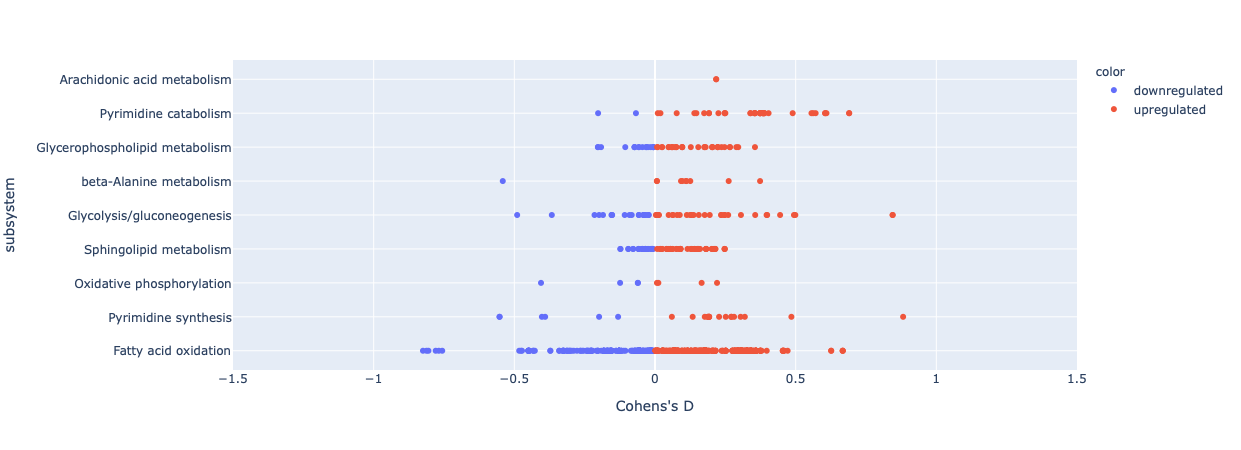

In [118]:
key = 'neurons'
plotly_category_plot(
    wilcoxon_test_results['single'],
    key + ' ' + ' vs. '.join(labels[key]),
)

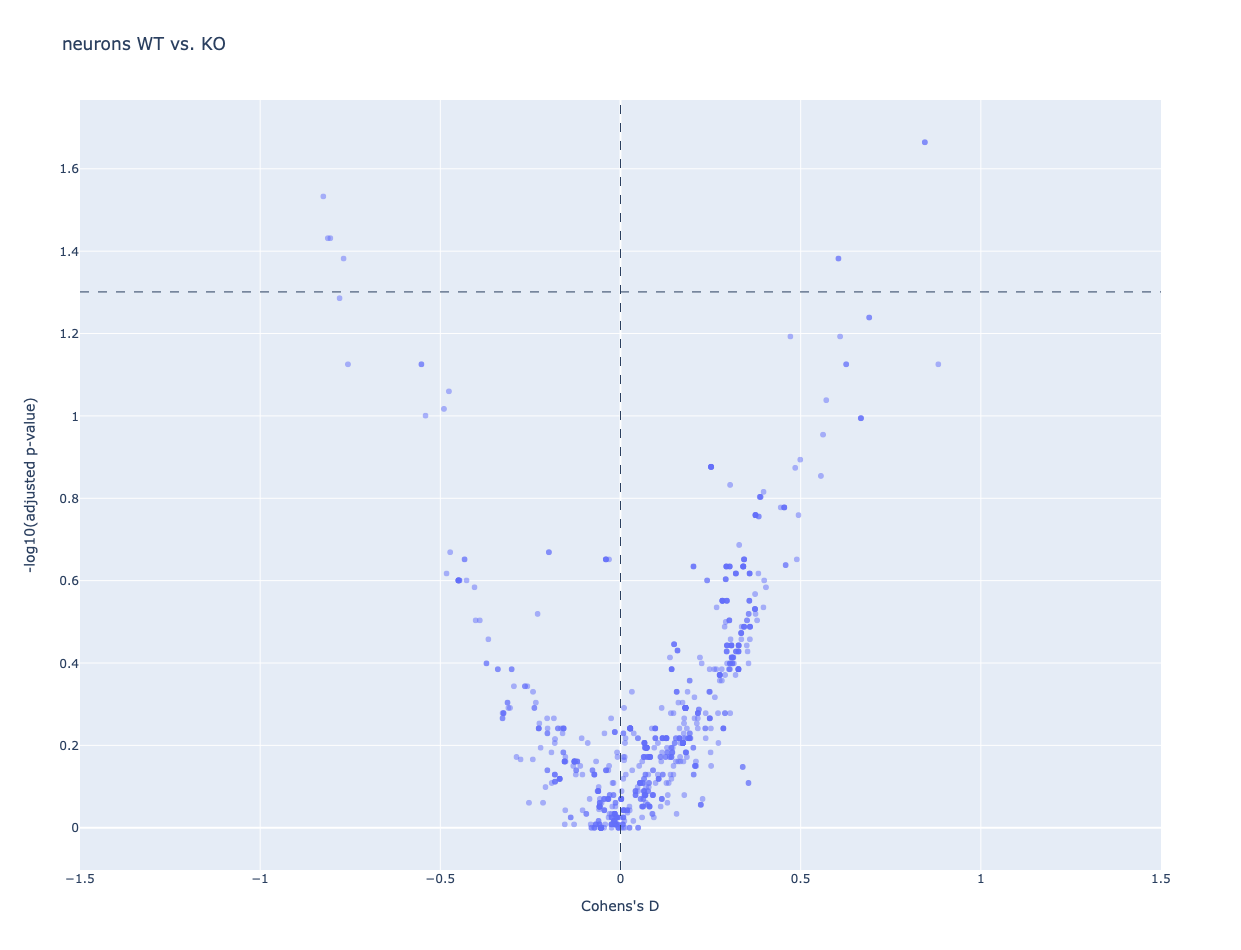

In [120]:
key = 'neurons'
plotly_vulcano_plot(
    wilcoxon_test_results['single'],
    key + ' ' + ' vs. '.join(labels[key]),
    pval_cutoff = 0.05,
    pval_column = 'wilcox_pval'
)

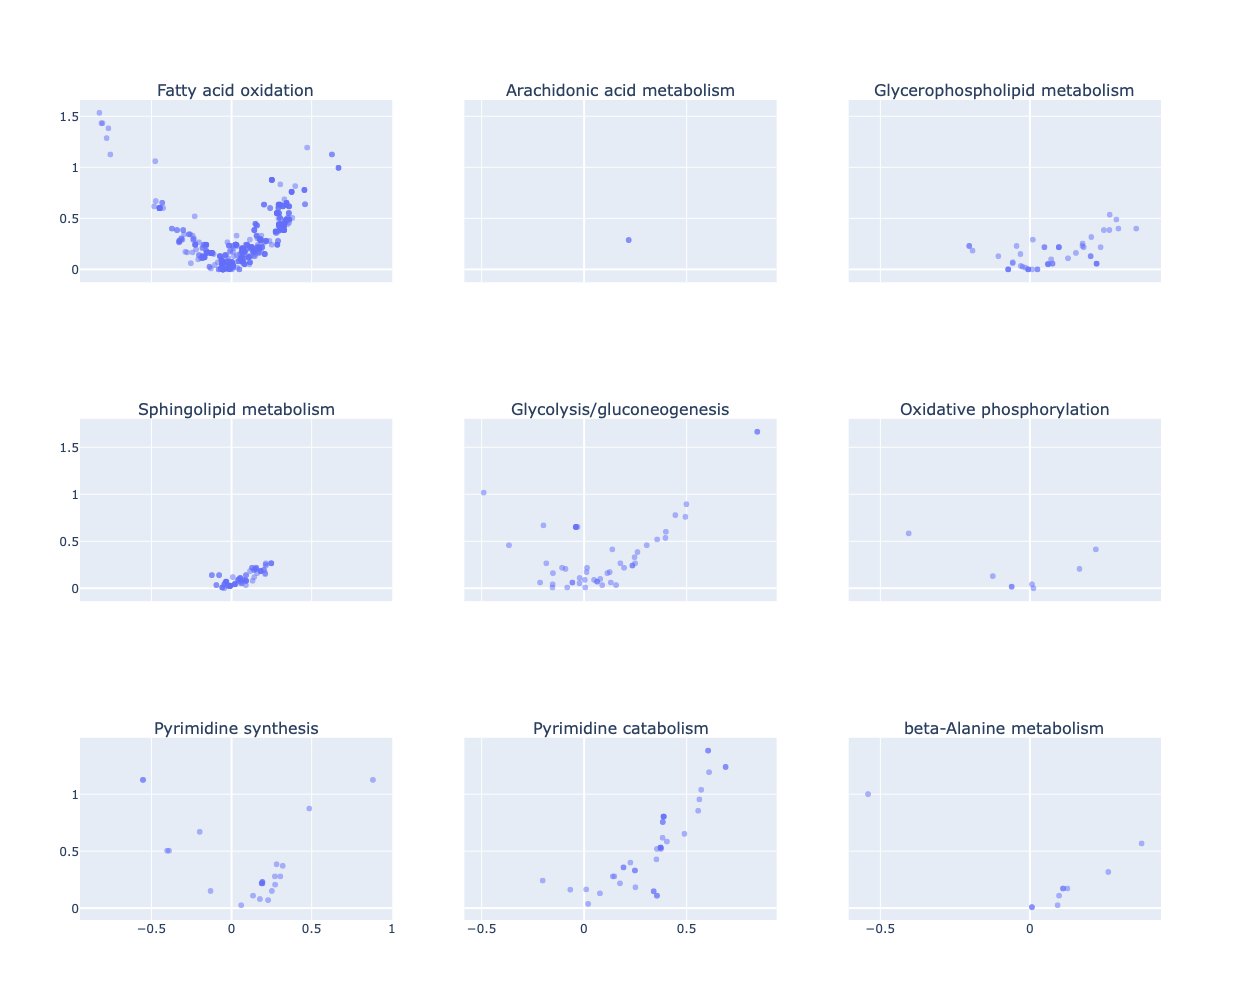

In [106]:
from plotly.subplots import make_subplots
fig = make_subplots(
    rows = 3, 
    cols = 3,
    subplot_titles = relevant_subsystems,
    shared_xaxes = True,
    shared_yaxes = True,
    x_title = '-log10(wilcoxon_pval)'
)
data = wilcoxon_test_results['single']
for i, j, subsystem in zip(
    [1, 1, 1, 2, 2, 2, 3, 3, 3], 
    [1, 2, 3, 1, 2, 3, 1, 2, 3], 
    relevant_subsystems):
    fig.add_trace(
        plotly_vulcano_plot(
            data[data.subsystem == subsystem],
            key + ' ' + ' vs. '.join(labels[key]) + subsystem,
            pval_cutoff = 0.05,
            pval_column = 'wilcox_pval'
        ).data[0],
        row = i, 
        col = j
    )
    
fig.update_layout(
    width = 1000,
    height = 1000
)
fig.show()

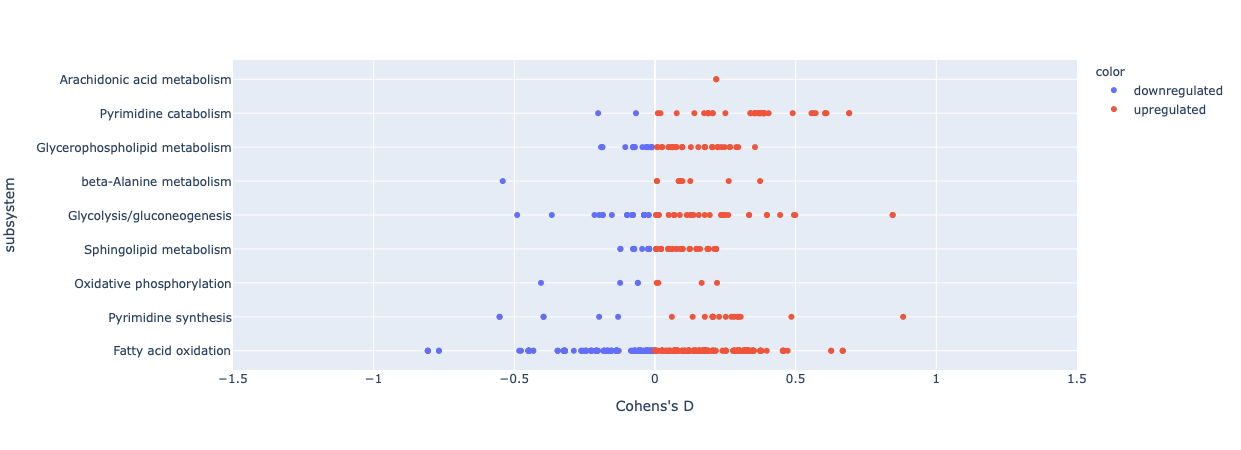

In [89]:
key = 'neurons'
plotly_category_plot(
    wilcoxon_test_results['meta'],
    key + ' ' + ' vs. '.join(labels[key]),
)

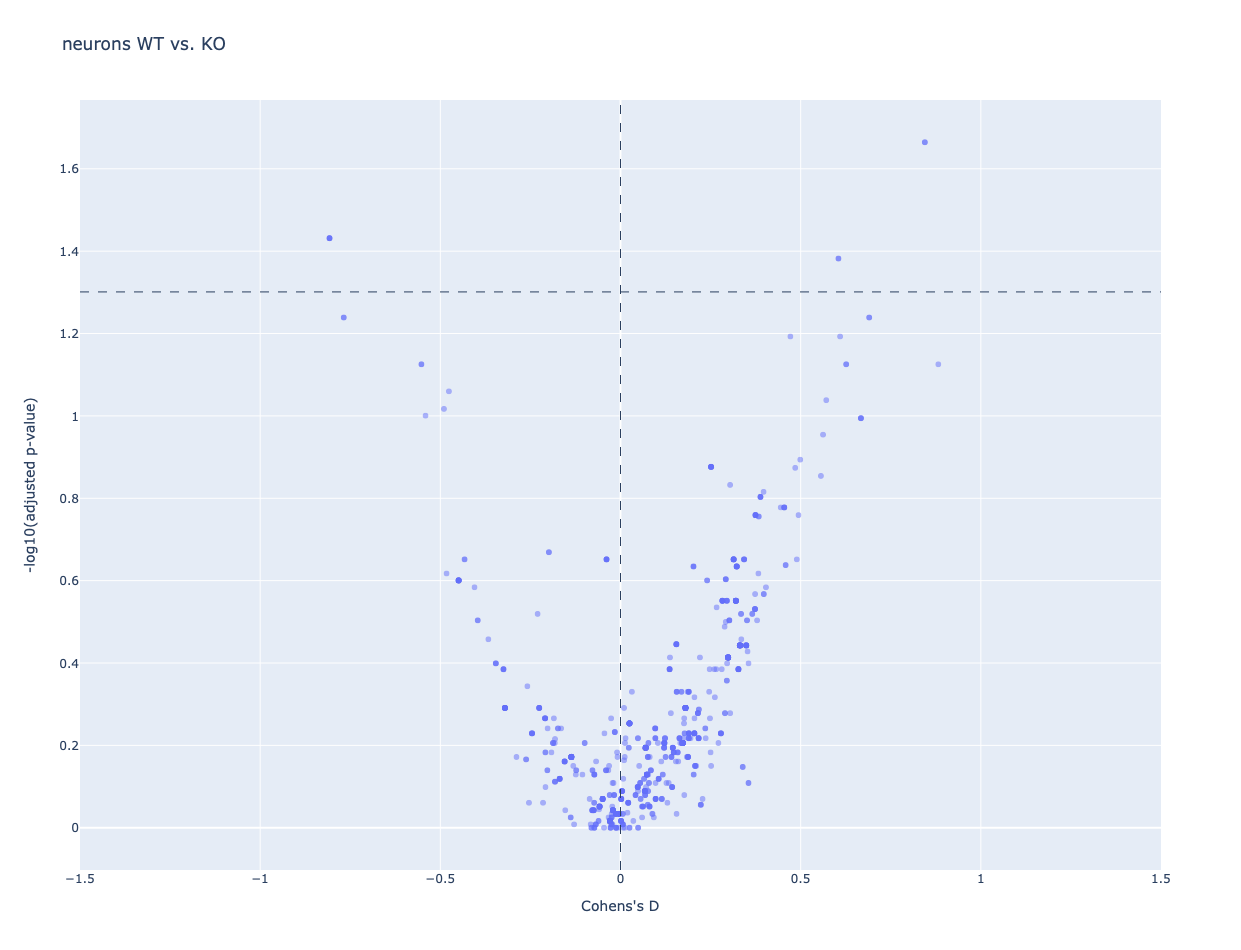

In [72]:
key = 'neurons'
plotly_vulcano_plot(
    wilcoxon_test_results['meta'],
    key + ' ' + ' vs. '.join(labels[key]),
    pval_cutoff = 0.05,
    pval_column = 'wilcox_pval'
)